In [38]:
from pynq import Overlay
from pynq import allocate
import pynq.lib.dma
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.signal import lfilter
from scipy import signal              
import IPython

### Step_1: Create a sinusoid signal

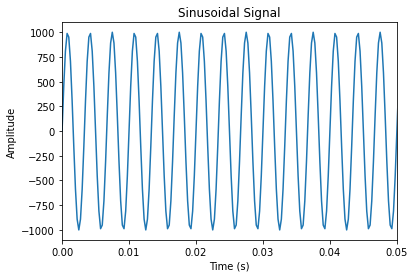

In [39]:
# a sinusoidal equation is: y(t) = Asin(2πft + φ)

sample_rate = 4000               
seconds = 5                        

ti = [t/sample_rate for t in range(sample_rate * seconds)]

# The signal variables
Amplitude = 1000                         
Frequency = 300   # Hz
phase_offset = 0                  

# Put all the above signal variables into our sinusoidal equation
sinusoid_signal = [(Amplitude*np.sin((Frequency*2*np.pi*(t))+ phase_offset)) for t in ti]

plt.xlabel('Time (s)')  
plt.ylabel('Amplitude')
plt.title('Sinusoidal Signal')
plt.xlim(0, 0.05)                          
plt.plot(ti, sinusoid_signal) 
IPython.display.display(IPython.display.Audio(sinusoid_signal, rate=sample_rate))

### Step 2: Create a white noise based on “standard normal” distribution

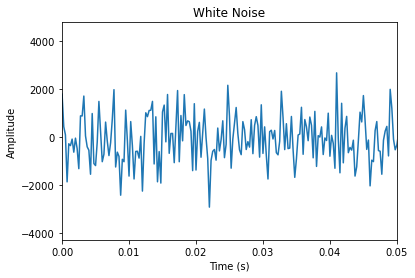

In [40]:
# np.random.seed() makes the random numbers and the same set of numbers will appear every time
np.random.seed(3)            

# The numpy.random.randn() function creates an array of specified shape. 
# And fills it with random values as per standard normal distribution.   
# white_noise = 1000 * np.random.randn(np.array(len(ti)).astype(np.int32))
white_noise = 1000*np.random.randn(len(ti)) 


plt.xlim(0, 0.05)
plt.title('White Noise')
plt.xlabel('Time (s)')  
plt.ylabel('Amplitude')
plt.plot(ti, white_noise)
IPython.display.display(IPython.display.Audio(white_noise, rate=sample_rate))

### Step_3: Add white noise to the the sinusoid signal

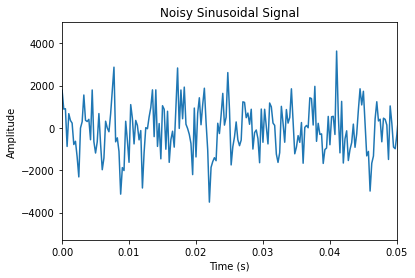

In [41]:
# noisy_signal = sinusoid_signal + white_noise
noisy_signal = np.array(sinusoid_signal + white_noise).astype(np.int32)


plt.xlim(0, 0.05)
plt.title('Noisy Sinusoidal Signal')
plt.xlabel('Time (s)')  
plt.ylabel('Amplitude')
plt.plot(ti, noisy_signal)
IPython.display.display(IPython.display.Audio(noisy_signal, rate=sample_rate))

### Step_4: Denoise the noisy signal with software

Software FIR execution time:  0.011468887329101562


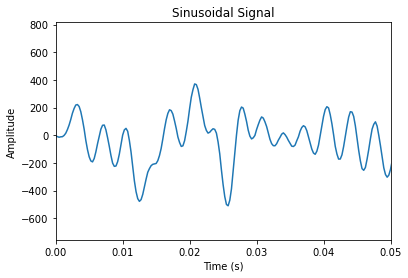

In [42]:
# define the coefficients
coeffs = [-255,-260,-312,-288,-144,153,616,1233,1963,2739,3474,4081,4481,4620,4481,4081,3474,2739,1963,1233,616,153,-144,-288,-312,-260,-255]

start_time = time.time()                               # use time.time() to measure elapsed time
sw_fir_output = lfilter(coeffs,70e3,noisy_signal)      # FIR filter
stop_time = time.time()
sw_exec_time = stop_time - start_time
print('Software FIR execution time: ',sw_exec_time)

# Plot the result to notebook

plt.xlabel('Time (s)')  
plt.ylabel('Amplitude')
plt.title('Sinusoidal Signal')
plt.xlim(0, 0.05)                          
plt.plot(ti, sw_fir_output) 

IPython.display.display(IPython.display.Audio(sw_fir_output, rate=sample_rate))

### Step_5: Denoise the noisy signal with hardware

In [43]:
# Load the overlay
overlay = Overlay('FIR_filter.bit')

# Load the FIR DMA
dma = overlay.filter.fir_dma

Hardware FIR execution time:  0.004071235656738281
Hardware acceleration factor:  2.817053174045444


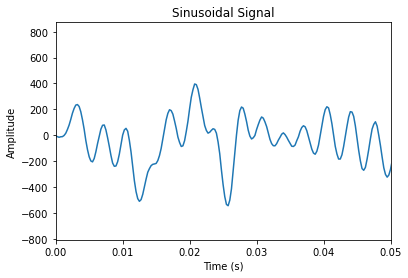

In [44]:
# Allocate buffers for the input and output signals
in_buffer = allocate(shape=(len(noisy_signal),),dtype=np.int32)
out_buffer = allocate(shape=(len(noisy_signal),),dtype=np.int32)

# Copy the signal to the in_buffer
np.copyto(in_buffer, noisy_signal)

# Trigger the DMA transfer and wait for the result
start_time = time.time()                        # use time.time() to measure elapsed time
dma.sendchannel.transfer(in_buffer)
dma.recvchannel.transfer(out_buffer)
dma.sendchannel.wait()
dma.recvchannel.wait()
stop_time = time.time()
hw_exec_time = stop_time - start_time

print('Hardware FIR execution time: ', hw_exec_time)
print('Hardware acceleration factor: ', sw_exec_time / hw_exec_time)



# Free the buffers
in_buffer.close()
out_buffer.close()


# Plot to the notebook
plt.xlabel('Time (s)')  
plt.ylabel('Amplitude')
plt.title('Sinusoidal Signal')
plt.xlim(0, 0.05)                          
plt.plot(ti, out_buffer) 

IPython.display.display(IPython.display.Audio(out_buffer, rate=sample_rate))